# Riesgo Operacional (RO)
---

Esta implemtación tien como objetivo comprender y aplicar el Enfoque de Distribución de Pérdidas (Loss Distribution Approach -LDA) para el cálculo de capital por Riesgo Operacional (OpVaR) mediante simulación de Monte Carlo.

Recordemos que hay diferentes enfoques para el calculo del Capital x RO
Los bancos deben reservar capital para cubrir estas pérdidas. Históricamente, los enfoques han variado en sofisticación:

## Modelos de estimación de Capital x RO

**Basel II permite 3 enfoques:**

**1 . Indicador Básico (BIA) → $\alpha: 15\%$ de ingresos brutos promedio**

$$Capital_{RO} = \alpha \times \times IB\ \ \text{(Ingresos Brutos Promedios - últimos 3 años)}$$


**2 . Enfoque Estándar (TSA) → x% variable por línea de negocio**

$$Capital_{RO} = \sum_{i=1}^{8} \beta_i \times IB_i \text{(por línea de negocio)}$$

| **Línea de Negocio** | **β (%)** | **Descripción breve** |
|----------------------|----------|------------------------|
| **Financiamiento Corporativo** *(Corporate Finance)* | **18** | M&A, sindicación, emisiones de valores, asesoría financiera. |
| **Trading & Sales** | **18** | Operaciones en mercados (acciones, renta fija, derivados, FX). |
| **Banca Minorista** *(Retail Banking)* | **12** | Cuentas, tarjetas, préstamos personales, hipotecas. |
| **Banca Comercial** *(Commercial Banking)* | **15** | Préstamos a PYMES, líneas de crédito, factoring. |
| **Procesamiento de Pagos y Liquidación** *(Payment & Settlement)* | **18** | Transferencias, compensación, sistemas de pago (ACH, SWIFT). |
| **Servicios de Agencia** *(Agency Services)* | **15** | Custodia, administración de fondos, escrow. |
| **Gestión de Activos** *(Asset Management)* | **12** | Fondos mutuos, carteras discrecionales, ETF. |
| **Intermediación Minorista** *(Retail Brokerage)* | **12** | Ejecución de órdenes para clientes minoristas. |

--------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Cálculo BIA vs TSA

# Datos del banco (en millones de COP)
ingresos = {
    'Banca Corporativa': 120000,
    'Banca Minorista': 80000,
    'Trading': 30000,
    'Pagos': 15000
}

#  BIA
ingreso_total = sum(ingresos.values())
capital_bia = ingreso_total * 0.15
print(f"Capital por BIA: {capital_bia:,.0f} millones")

Capital por BIA: 36,750 millones


In [ ]:
# Factores Basel TSA
factores_tsa = {
    'Banca Corporativa': 0.18,
    'Banca Minorista': 0.12,
    'Trading': 0.18,
    'Pagos': 0.18
}

# TSA
capital_tsa = sum(ingresos[linea] * factores_tsa[linea] for linea in ingresos)
print(f"Capital por TSA: {capital_tsa:,.0f} millones")

Capital por TSA: 39,300 millones


In [ ]:
ca_ro = pd.DataFrame({
    'Enfoque': ['BIA', 'TSA'],
    'Capital Requerido': [capital_bia, capital_tsa]
})

ca_ro

,Enfoque,Capital Requerido
0,BIA,36750.0
1,TSA,39300.0


El Enfoque de Distribución de Pérdidas (LDA)
---

1. Pérdida Agregada (L): Es la suma de todas las pérdidas en un año.

2. Componentes del LDA: Se modelan dos cosas por separado. El LDA es la técnica central en el modelado de RO y radica en descomponer el problema de las pérdidas totales en dos partes separadas:

* **'1. Modelado de Frecuencia**: ¿Cuántas veces sufriremos un evento de pérdida en un año? Para ello, usamos distribuciones de conteo (discretas), como la Distribución Poisson.

* **'2. Modelado de Severidad**: Si ocurre un evento, ¿de qué tamaño (en dinero) será esa pérdida? Para ello, usamos distribuciones continuas y de "colas pesadas", como la Log-Normal o la Exponencial.

$$ \text{Pérdida Agregada (L)}: L = \sum_{i=1}^{N} X_i $$

El Desafío: No hay una solución analítica (fórmula cerrada) para la distribución de $L$.

La Solución: **Simulación de Monte Carlo** (**Objetivo**). No vamos a modelar la pérdida total directamente. Vamos a implemetar una Simulación de Monte Carlo (MC) para combinar estas dos distribuciones y generar una distribución resultante de Pérdidas Anuales Agregadas. Sobre esa distribución final, calculamos nuestras medidas de capital regulatorio: OpVaR y OpES.

**NOTA:** LDA requiere 5+ años de datos internos; datos sintéticos/exteriores subestiman si no escalados.


Paso 1. Importar Librerías y Cargar Datos
---
Importamos las librerías necesarias de Python y cargamos el conjunto de datos "BaselRO.xlsx"

In [ ]:
# Librerias
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import scipy.stats as stats
import datetime
import warnings      # Manejo de warnings
warnings.filterwarnings('ignore')

In [ ]:
# Carga y Preparación de Datos
df = pd.read_excel("BaselOR.xlsx")

In [ ]:
# Filtramos por la Línea de Negocio 'PS' (Payment & Settlement)
df_ps = df[df['Business Line'] == 'PS'].copy()

In [ ]:
# Calculamos la Pérdida Neta (Gross Loss - Recovery)
df_ps['Net Loss'] = df_ps['Gross Loss Amount'] - df_ps['Recovery Amount']

In [ ]:
# Convertimos la columna 'Date' a formato datetime de pandas
df_ps['Date'] = pd.to_datetime(df_ps['Date'], format='%d/%m/%Y')

In [ ]:
# Filtramos solo las filas que representan un evento de pérdida real (Net Loss > 0)
df_losses = df_ps[df_ps['Net Loss'] > 0].copy()

print(f"Total de eventos de pérdida neta en 'PS': {len(df_losses)}")
print(df_losses.head())

Total de eventos de pérdida neta en 'PS': 196
    ID       Date Business Line Risk Category  Gross Loss Amount  \
0    1 2016-06-07            PS          EPWS        4771.252962   
6    7 2018-06-01            PS         FRAUD        3767.924667   
16  17 2017-11-23            PS          EDPM       11889.905751   
25  26 2014-08-20            PS          EPWS        3568.968225   
30  31 2014-12-02            PS          CPBP        9925.968025   

    Recovery Amount     Net Loss  
0       2532.298219  2238.954743  
6       2339.118974  1428.805693  
16      7039.615081  4850.290670  
25       378.629604  3190.338622  
30      7114.914411  2811.053614  


Paso 2. Modelado de Frecuencia (¿Cuántas veces?)
---
Aquíj buscamos contar cuántos eventos de pérdida ocurrieron por período de tiempo. Se puede usar la función resample de pandas, que es mucho más robusta.

In [ ]:
# Agrupamos los eventos de pérdida por año ('1Y')
# Contamos cuántos eventos ('ID') ocurrieron en cada período
frequency_data = df_losses.set_index('Date').resample('1Y')['ID'].count()
print(frequency_data.head())

Date
2009-12-31    20
2010-12-31    15
2011-12-31    16
2012-12-31    17
2013-12-31    23
Freq: YE-DEC, Name: ID, dtype: int64


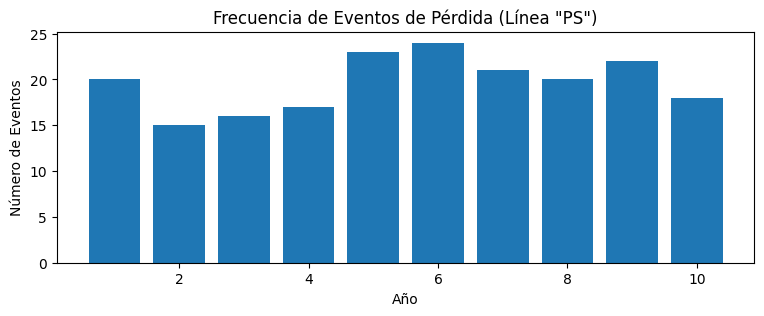

In [ ]:
# Visualizamos la frecuencia de eventos
yrs = [1,2,3,4,5,6,7,8,9,10]
plt.figure(figsize=(9, 3))
plt.bar(yrs,frequency_data)
plt.title('Frecuencia de Eventos de Pérdida (Línea "PS")')
plt.ylabel('Número de Eventos')
plt.xlabel('Año')
plt.show()

**Ajuste de Distribución de Frecuencia**

Para datos de conteo (0, 1, 2... eventos), la distribución estándar es la Poisson. Esta distribución se define por un solo parámetro, $\lambda$ (lambda), que es simplemente la media de los eventos por período.

In [ ]:
# Ajustamos una distribución de Poisson
# Lambda (λ) es la media de eventos por año
lambda_freq = frequency_data.mean()
print(f"Parámetro λ (lambda) Anual estimado (eventos/año): {lambda_freq:.4f}")

Parámetro λ (lambda) Anual estimado (eventos/año): 19.6000


Paso 3. Modelado de Severidad (¿De qué tamaño es la pérdida?)
---
Aqui se busca analizar la distribución de los montos de pérdida (Net Loss) cada vez que ocurre un evento.

In [ ]:
# Ya tenemos los datos de severidad en df_losses['Net Loss']
severity_data = df_losses['Net Loss']
print(severity_data.describe())

count       196.000000
mean       8838.283678
std       45213.743688
min         166.038125
25%         907.775233
50%        1947.069722
75%        4015.221719
max      588759.607108
Name: Net Loss, dtype: float64


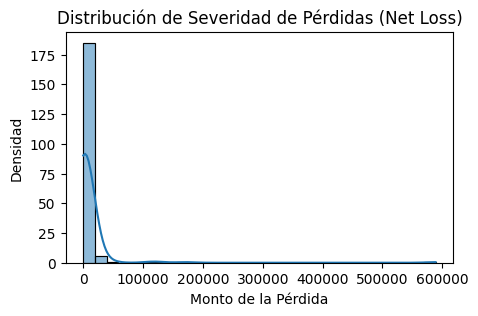

In [ ]:
# Visualizamos la distribución de severidad
plt.figure(figsize=(5,3))
sns.histplot(severity_data, kde=True, bins=30)
plt.title('Distribución de Severidad de Pérdidas (Net Loss)')
plt.xlabel('Monto de la Pérdida')
plt.ylabel('Densidad')
plt.show()

La distribución suele ser altamente asimétrica a la derecha (right-skewed) y tiene una cola pesada (heavy tail). Esto es típico del riesgo operacional: muchas pérdidas pequeñas y unas pocas pérdidas catastróficas.

**Ajuste de Distribución de Severidad**

Sabemos que (como se observa en el gráfico) una distribución Normal es inapropiada. Vamos a probar mejores ditribuciones: la Exponencial y la Log-Normal (muy común en finanzas).

Usaremos el test de Kolmogorov-Smirnov (K-S) para ver qué tan bien se ajustan.

* H0: los datos siguen una distribución normal
* H1: los datos NO siguen una distribución normal

In [ ]:
# Pruebas de Bondad de Ajuste (Goodness-of-Fit)
# 1. Prueba vs. Normal
D_norm, p_norm = stats.kstest(severity_data, 'norm', args=(severity_data.mean(), severity_data.std()))
print(f"Test K-S vs. Normal: p-value = {p_norm}")

Test K-S vs. Normal: p-value = 1.8007911704821458e-32


In [ ]:
# 2. Prueba vs. Exponencial
# El parámetro 'scale' de la exponencial es 1/lambda, que es la media.
D_exp, p_exp = stats.kstest(severity_data, 'expon', args=(0, severity_data.mean()))
print(f"Test K-S vs. Exponencial: p-value = {p_exp}")

Test K-S vs. Exponencial: p-value = 1.219924923315195e-27


In [ ]:
# 3. Prueba vs. Log-Normal
# Primero, ajustamos la distribución para obtener sus parámetros
shape_sev, loc_sev, scale_sev = stats.lognorm.fit(severity_data, floc=0)
D_log, p_log = stats.kstest(severity_data, 'lognorm', args=(shape_sev, loc_sev, scale_sev))
print(f"Test K-S vs. Log-Normal: p-value = {p_log}")

Test K-S vs. Log-Normal: p-value = 0.22543695795261132


Además, se pueden usar diagnósticos visuales (Q-Q plots) y otras pruebas (Anderson-Darling, AIC). Para este ejercicio, asumiremos que la Log-Normal es nuestra mejor candidata.

Nota: Para esta simulación, usaremos los parámetros ajustados de la Log-Normal, ya que es metodológicamente más robusta para modelar la severidad que la Exponencial.

Paso 4. Simulación de Monte Carlo
---

Aquí es donde unimos Frecuencia y Severidad.

**Metodología**: Vamos a simular 10.000 o 100.000 "futuros" posibles (o incluso más iteraciones) para el próximo año. Cada iteración es 1 año simulado.

* Paso 1 (Frecuencia): Usando la distribución de Poisson (con $\lambda$ anual), "¿Cuántos eventos de pérdida ocurrieron este año?".
* Paso 2 (Severidad): Si N > 0, usamos la distribución Log-Normal, "Obtenemos N montos de pérdida". (Ej. [500, 1200, 300, 8000, ...]).
* Paso 3 (Agregación): Sumamos esas N pérdidas para obtener la Pérdida Anual Total para ese año simulado. (Ej. 500 + 1200 + 300 + 8000 = 10000).

Como resultado, se obtiene un vector muy grande (de 10.000 o 100.000) Pérdidas Anuales Totales posibles.

In [ ]:
# Simulación de Monte Carlo (LDA)
n_sim = 10_000  # Número de perdidas a simular en el año
total_annual_losses = []

# Parámetros de Frecuencia (Poisson) - Ya calculados
lambda_freq

# Parámetros de Severidad (Log-Normal) - Ya ajustados
# shape_sev, loc_sev, scale_sev

np.float64(19.6)

In [ ]:
for i in range(n_sim):
    # 1. Simular # de eventos en un año desde Poisson
    num_events = stats.poisson.rvs(lambda_freq)

    # 2. Si hay eventos, simular el monto de cada uno desde Log-Normal
    if num_events > 0:
        losses = stats.lognorm.rvs(s=shape_sev, loc=loc_sev, scale=scale_sev, size=num_events)

        # 3. Agregar la pérdida total del año
        total_annual_losses.append(np.sum(losses))
    else:
        # Si no hubo eventos, la pérdida del año es 0
        total_annual_losses.append(0)

total_annual_losses = np.array(total_annual_losses)

Paso 5. Cálculo de Capital: OpVaR y OpES
----

Ahora que tenemos nuestra distribución de Pérdidas Anuales Agregadas (los 10,000 resultados), podemos calcular el capital.

**1 . OpVaR (Operational Value at Risk) 99.9%**:

¿Cuál es la pérdida máxima que no esperamos superar el 99.9% del tiempo? Es el percentil 99.9 de nuestra distribución simulada.

**2 . OpES (Operational Expected Shortfall) 99.9%:**

En el 0.1% de los peores escenarios (cuando las pérdidas superan el VaR), ¿cuál es la pérdida promedio que esperamos? Es la media de todas las pérdidas que son mayores que el OpVaR.


In [ ]:
# Cálculo de Capital
confidence = 99.9  # Nivel de Confianza (Basilea exige 99.9%)

# 1. Calcular OpVaR
op_var_999 = np.percentile(total_annual_losses, confidence)

# 2. Calcular OpES
losses_above_var = total_annual_losses[total_annual_losses > op_var_999]
op_es_999 = losses_above_var.mean()

print(" Resultados de Capital Regulatorio: ")
print(f"OpVaR (99.9%): {op_var_999:,.2f}")
print(f"OpES (99.9%):  {op_es_999:,.2f}")

 Resultados de Capital Regulatorio: 
OpVaR (99.9%): 428,073.93
OpES (99.9%):  573,554.31


**Visualización Final**

Grafiquemos la distribución final de pérdidas anuales y marquemos nuestro capital

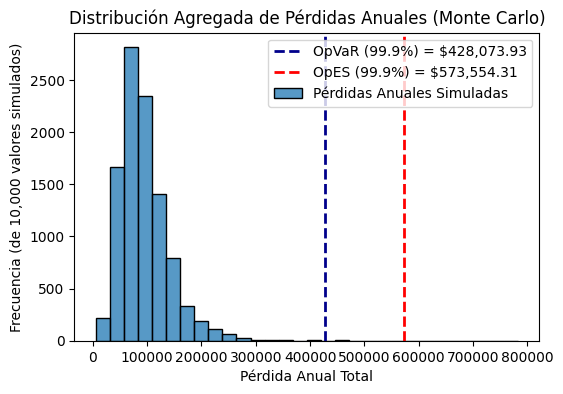

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(total_annual_losses, kde=False, bins=30, label="Pérdidas Anuales Simuladas")

# Líneas de VaR y ES
plt.axvline(op_var_999, color='darkblue', linestyle='--', linewidth=2,
            label=f'OpVaR (99.9%) = ${op_var_999:,.2f}')

plt.axvline(op_es_999, color='red', linestyle='--', linewidth=2,
            label=f'OpES (99.9%) = ${op_es_999:,.2f}')

plt.title('Distribución Agregada de Pérdidas Anuales (Monte Carlo)')
plt.xlabel('Pérdida Anual Total')
plt.ylabel('Frecuencia (de 10,000 valores simulados)')
plt.legend()
plt.show()

# Extensiones
---

## 1. Teoría de Valores Extremos (EVT)

Un enfoque más robusto es dividir el problema en dos: el "cuerpo" de las pérdidas (las pequeñas y frecuentes) y la "cola" (las grandes y raras). Esto requiere:

**1 . Definir un Umbral (u)**: Elija un umbral alto (ej., el percentil 95 de las pérdidas).

**2 . Modelar el Cuerpo**: Modele las pérdidas debajo del umbral (el 95%) con una distribución estándar (Log-Normal, Gamma, etc.).

**3 . Modelar la Cola (EVT)**: Modele las pérdidas por encima del umbral usando la Distribución de Pareto Generalizada (GPD). Este modelo está diseñado matemáticamente para analizar eventos extremos

**Para tener en cuenta**:

El método Peaks-Over-Threshold (POT), una de las técnicas principales de la Teoría de Valores Extremos (EVT). El fundamento teórico proviene de modelar únicamente la cola de la distribución de pérdidas (es decir, las pérdidas por encima de un umbral alto $u$) con una distribución específica llamada **Distribución de Pareto Generalizada (GPD)**.

**1. Fórmula del VaR**

$$ VaR = u + (scale/c) * ( ( (N/n_u) * (1-q) )**(-c) - 1 ) $$

Esta fórmula es la función cuantil (la inversa de la Función de Distribución Acumulada o CDF) del modelo GPD.

La EVT nos dice que para un umbral $u$ suficientemente alto, la distribución de los excesos de pérdida ($y = \text{Pérdida} - u$) sigue una GPD. La CDF de esta GPD (la probabilidad de que un exceso $y$ sea menor que cierto valor) es:

$$F(y) = 1 - (1 + \frac{c \cdot y}{scale})^{-1/c}$$

Donde $c$ es el parámetro de forma/cola y $scale$ es la escala.

**2. Invertir la Fórmula (el Cuantil)**

Para obtener el VaR, necesitamos el valor para una probabilidad dada. Esto requiere invertir algebraicamente la fórmula anterior para "resolver para $y$". Si $p$ es nuestra probabilidad objetivo en la cola, el valor $y$ correspondiente es:

$$y = \frac{scale}{c} \cdot ((1-p)^{-c} - 1)$$

El VaR Total: El valor total del VaR no es solo el exceso $y$, sino el umbral $u$ más el exceso $y$.

$$VaR = u + y = u + \frac{scale}{c} \cdot ((1-p)^{-c} - 1)$$


**3. El Ajuste de Probabilidad**

Queremos el cuantil $q$ (ej. 0.999) de la distribución total, no de la cola. $p$ en nuestra fórmula es $P(\text{Pérdida} > VaR | \text{Pérdida} > u)$. Es una probabilidad condicional.

Necesitamos traducir $q=0.999$ (probabilidad total) a $p$ (probabilidad condicional).La probabilidad de estar por encima de $u$ (en la cola) la estimamos con nuestros datos:

$$P(\text{Pérdida} > u) \approx \frac{n_u}{N}$$

donde $n_u$ es el número de pérdidas sobre el umbral y $N$ es el total.

La probabilidad que buscamos es $1-q$ (ej. 0.001).

La probabilidad condicional $(1-p)$ es el ratio de ambas:

$$(1-p) = \frac{P(\text{Pérdida} > VaR)}{P(\text{Pérdida} > u)} = \frac{1-q}{n_u / N} = \frac{N \cdot (1-q)}{n_u}$$

La Fórmula Final: Sustituimos este $(1-p)$ en nuestra fórmula del VaR del Paso 3 y obtenemos:

$$VaR_q = u + \frac{scale}{c} \cdot ((\frac{N \cdot (1-q)}{n_u})^{-c} - 1)$$

**Para ES se obtiene**:

$$ES = \frac{VaR_q + scale - c \cdot u}{1-c}$$

In [ ]:
# Paso: los datos
df = pd.read_excel("BaselOR.xlsx")
df_ps = df[df['Business Line'] == 'CB'].copy() # Filtramos por la Línea de Negocio 'CB'
df_ps['Net Loss'] = df_ps['Gross Loss Amount'] - df_ps['Recovery Amount'] # Calculamos la Pérdida Neta (Gross Loss - Recovery)
df_ps['Date'] = pd.to_datetime(df_ps['Date'], format='%d/%m/%Y') # Convertimos la columna 'Date' a formato datetime de pandas
df_losses = df_ps[df_ps['Net Loss'] > 0].copy() # Filtramos solo las filas que representan un evento de pérdida real (Net Loss > 0)

print(f"Total de eventos de pérdida neta en la línea: {len(df_losses)}")
df_losses.head(2)

Total de eventos de pérdida neta en la línea: 182


,ID,Date,Business Line,Risk Category,Gross Loss Amount,Recovery Amount,Net Loss
3,4,2016-10-02,CB,DPA,2413.270491,736.294369,1676.976122
13,14,2011-05-18,CB,EPWS,2022.154309,1302.073053,720.081256


In [ ]:
# Filtramos la línea 'PS' y obtenemos la severidad (Net Loss > 0)
severity_data = df_losses[
    (df_losses['Business Line'] == 'CB') &
    (df_losses['Net Loss'] > 0)
]['Net Loss']

n = len(severity_data) # Número total de pérdidas
print(f"Total de pérdidas históricas en 'PS': {n}")

Total de pérdidas históricas en 'PS': 182


In [ ]:
# 2. Selección del Umbral (u)
# Un método común (y simple) es elegir un percentil alto, como el 90% o 95%.
# Usaremos el 95% para tener suficientes datos en la cola.

umbral_u = severity_data.quantile(0.95)
print(f"Umbral (u) al percentil 95: ${umbral_u:,.2f}")

Umbral (u) al percentil 95: $28,218.61


In [ ]:
# Obtenemos solo los "excesos" (la parte de la pérdida mayores al umbral)
excesos = severity_data[severity_data > umbral_u] - umbral_u
n_u = len(excesos) # Número de pérdidas en la cola
print(f"Número de pérdidas por encima del umbral (n_u): {n_u}")

Número de pérdidas por encima del umbral (n_u): 10


In [ ]:
# 3. Ajuste de la Distribución de Pareto Generalizada (GPD)

# La GPD (stats.genpareto) tiene 3 parámetros:
# c (shape): El más importante, define la "pesadez" de la cola.
# loc (location): El punto de inicio (para excesos, es 0).
# scale (escala): El factor de escala.
# Usamos floc=0 para forzar la localización a 0 (los excesos empiezan en 0)
c, loc, scale = stats.genpareto.fit(excesos, floc=0)

print(f"Parámetros GPD ajustados:")
print(f"  Shape (c):   {c:.4f}")
print(f"  Scale (β): {scale:,.2f}")

Parámetros GPD ajustados:
  Shape (c):   0.4129
  Scale (β): 32,764.28


In [ ]:
# 4. Cálculo de Capital (VaR op y ES op) con EVT
# Usamos la fórmula analítica del VaR para el modelo POT

q = 0.999 # Nuestro nivel de cuantil (o percentil) (99.9%)

# Fórmula del VaR (Tail VaR)
# VaR = u + (scale/c) * ( ( (N/n_u) * (1-q) )**(-c) - 1 )
term_ratio = (n / n_u) * (1 - q)
term_pow = (term_ratio ** (-c)) - 1
var_evt = umbral_u + (scale / c) * term_pow

# Fórmula del ES
# ES = (VaR_q + scale - c*u) / (1 - c)
# (Solo si c < 1, lo cual es casi siempre el caso) - Revisar calculo de c
es_evt = (var_evt + scale - c * umbral_u) / (1 - c)

print(f"Resultados de Capital para la línea (Método EVT):")
print(f"  OpVaR (99.9%): ${var_evt:,.2f}")
print(f"  OpES (99.9%):  ${es_evt:,.2f}")

Resultados de Capital para la línea (Método EVT):
  OpVaR (99.9%): $363,785.48
  OpES (99.9%):  $655,580.94


Comparemos con los resultados iniciales:

In [ ]:
print(" Resultados de Capital Regulatorio: ")
print(f"OpVaR (99.9%): {op_var_999:,.2f}")
print(f"OpES (99.9%):  {op_es_999:,.2f}")

 Resultados de Capital Regulatorio: 
OpVaR (99.9%): 428,073.93
OpES (99.9%):  573,554.31


**¿Por qué los resultados son diferentes?**

El modelo LDA (Log-Normal) usa *todos* los datos para estimar la cola. El modelo EVT (GPD) asume que *solo* los datos de la cola (el 5% superior) saben cómo comportarse en el extremo. Generalmente, el EVT produce estimaciones de VaR más altas y se considera más conservador y preciso para el riesgo de cola.

In [ ]:
# ------------------------------------------------------------------------------------------------

## 2. Modelos de Severidad

El modelo actual asume que las pérdidas siguen una distribución Log-Normal. ¿Por qué no una Weibull, Gamma o Pareto?

Se pueden implementar Pruebas de Bondad de Ajuste (Goodness-of-Fit) para identificar auqelllas distribuciones que se ajustan mejor.

Para ello, se crea una lista de distribuciones candidatas: [stats.lognorm, stats.weibull_min, stats.gamma, etc..]

Luego se escoge la distribución con mejor SSE, AIC o el mayor p-value del test K-S.


In [ ]:
# Usamos los mismos datos de severidad de 'CB'
severity_data = df_losses[
    (df_losses['Business Line'] == 'CB') &
    (df_losses['Net Loss'] > 0)
]['Net Loss']

In [ ]:
# Pre-procesamiento de los datos
# Ordenamos los datos (necesario para SSE)
sorted_data = np.sort(severity_data)
n = len(sorted_data)
# Calculamos la Curva Empírica (ECDF)
y_ecdf = np.arange(1, n + 1) / n

In [ ]:
# 1. Definimos la lista de Distribuciones Candidatas (para ajustar)
# (Añadir/quitar de aquí es fácil)
dist_candidatas = [
    stats.lognorm,     # Log-Normal (nuestra base)
    stats.gamma,       # Gamma
    stats.weibull_min, # Weibull
    stats.genpareto    # Pareto Generalizada
]
print(f"Datos de severidad listos (n={n}).")
print(f"Dist. Candidatas a probar: {[d.name for d in dist_candidatas]}")

Datos de severidad listos (n=182).
Dist. Candidatas a probar: ['lognorm', 'gamma', 'weibull_min', 'genpareto']


In [ ]:
# 2. Cosntruimos un bucle de Ajuste y Evaluación de distrbuciones
results = []

for dist in dist_candidatas:
    try:
        # 1. Ajustar la distribución a los datos
        params = dist.fit(severity_data)

        # 2. Test K-S (Prueba de hipótesis)
        # Compara los datos con la distribución *usando los parámetros ajustados*
        D, p_value = stats.kstest(severity_data, dist.name, args=params)

        # 3. Calcular SSE (Suma de Errores Cuadrados)
        # Compara la ECDF (datos) vs la CDF (teórica)
        y_cdf = dist.cdf(sorted_data, *params)
        sse = np.sum((y_ecdf - y_cdf)**2)

        # Guardar resultados
        results.append((dist.name, p_value, sse, params))
        print(f"  Distribución analizada: {dist.name}")

    except Exception as e:
        print(f"  Falló el ajuste de {dist.name}: {e}")


  Distribución analizada: lognorm
  Distribución analizada: gamma
  Distribución analizada: weibull_min
  Distribución analizada: genpareto


In [ ]:
# 3. Resultados del ajuste
df_results = pd.DataFrame(results, columns=["Distribución", "p-value (K-S)", "SSE", "Parámetros"])

# Ordenamos por el mejor (p-value más alto, SSE más bajo)
df_results = df_results.sort_values(by=['p-value (K-S)', 'SSE'], ascending=[False, True])
df_results.reset_index(drop=True, inplace=True)

print("Resultados ordenados del mejor al peor ajuste:")
df_results

Resultados ordenados del mejor al peor ajuste:


,Distribución,p-value (K-S),SSE,Parámetros
0,lognorm,0.475996,0.143814,"(1.4965519061668138, 131.92490171054425, 2236...."
1,genpareto,0.188129,0.151836,"(0.8389637924283311, 123.59779919600385, 2246...."
2,weibull_min,0.019935,0.774375,"(0.6130669867846036, 158.2593665780041, 4863.9..."
3,gamma,0.000000,60.164036,"(5.5539247096716675e-05, 158.2593665780041, 4...."


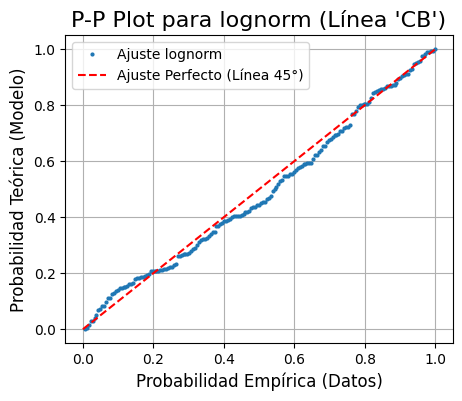

In [ ]:
# 4. Visualización (P-P Plot) ---
# Un P-P (Probability-Probability) plot compara la ECDF (datos) vs la CDF (teórica).
# Si el ajuste es bueno, los puntos caen sobre la línea de 45 grados.

# Tomamos los datos del mejor ajuste
best_dist_name = df_results.iloc[0]['Distribución']
best_dist = getattr(stats, best_dist_name)
best_params = df_results.iloc[0]['Parámetros']

# Obtenemos la CDF teórica del mejor ajuste
y_cdf_best = best_dist.cdf(sorted_data, *best_params)

# Graficamos
plt.figure(figsize=(5, 4))
plt.plot(y_ecdf, y_cdf_best, 'o', markersize=2, label=f'Ajuste {best_dist_name}')
plt.plot([0, 1], [0, 1], 'r--', label='Ajuste Perfecto (Línea 45°)')
plt.title(f'P-P Plot para {best_dist_name} (Línea \'CB\')', fontsize=16)
plt.xlabel('Probabilidad Empírica (Datos)', fontsize=12)
plt.ylabel('Probabilidad Teórica (Modelo)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

**Conclusión**

In [ ]:
print(f'La distribución con mejor ajuste para la severidad es: {df_results.iloc[0]['Distribución']}')

La distribución con mejor ajuste para la severidad es: lognorm


In [ ]:
print(f'con un p-value de: {df_results.iloc[0]['p-value (K-S)']}')

con un p-value de: 0.4759963227349915


In [ ]:
print(f'y un SSE de: {df_results.iloc[0]['SSE']}')

y un SSE de: 0.14381436271358822
